### Model: XGBoost. (eXtreme Gradient Boosting) 
The extreme gradient boosting (XGBoost) relies on a gradient descent optimization algorithm when minimizing the loss function, that makes it "efficient, flexible and portible".

In [1]:
#Connect to the database: 

library(RMySQL) 
con = dbConnect(MySQL(), dbname = "BnL",
                host = "mysql-1.cda.hhs.se", port = 3306,
                user = "bnl", password = "bnl@sse")

#Get dataset:

df = dbGetQuery(
  con, 
  "SELECT 
  IF(SUM(returned)/COUNT(returned)>0,1,0) AS is_returned, 
  MIN(class_desc) AS class_desc,
  MIN(group_desc) AS group_desc,
  MIN(division_desc) AS division_desc, 
  MIN(sustainability_id_desc) AS sustainability_id_desc
FROM Products 
JOIN Transactions 
  USING (item) 
GROUP BY item")
lapply( dbListConnections( dbDriver( drv = "MySQL")), dbDisconnect) #close connection
rm(con) #remove connection from environment
#use one hot encoding

#imputation 
library(dplyr)
df <- df %>% mutate(sustainability_id_desc	 = ifelse(is.na(sustainability_id_desc	), "Sustainable", sustainability_id_desc	))

# Only have 102 missing values for other desc
library(caret)
dmy = dummyVars(" ~ .", data = df)
trsf = data.frame(predict(dmy, newdata = df))
trsf = na.omit(trsf)

Loading required package: DBI



[[1]]
[1] TRUE


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: ggplot2

Loading required package: lattice



In [2]:
#Split the dataset into two thirds training set and one third test set: 
n = nrow(trsf)
set.seed(7313)
ntest = trunc(n / 3)
testid = sample(1:n, ntest)  
#Scaling is needed for the deep learning-algorithm (and used throughout)
x = model.matrix(is_returned ~ . - 1, data = trsf) %>% scale() 
y = trsf$is_returned

Fitting XGBoost to the Training set & Predicting the Test set results

In [3]:
library(xgboost)
set.seed(7313)
xgb = xgboost(
  data = x[-testid,], 
  nrounds = 10, 
  label = y[-testid], 
  objective = "binary:logistic")
xpred = ifelse(predict(xgb, x[testid,])>.5,1,0)
acc = round(mean(xpred == y[testid]),2)
acc


Attaching package: ‘xgboost’


The following object is masked from ‘package:dplyr’:

    slice




[1]	train-logloss:0.549804 
[2]	train-logloss:0.474066 
[3]	train-logloss:0.430988 
[4]	train-logloss:0.405839 
[5]	train-logloss:0.390956 
[6]	train-logloss:0.382253 
[7]	train-logloss:0.377228 
[8]	train-logloss:0.374034 
[9]	train-logloss:0.372295 
[10]	train-logloss:0.371153 


[1] 0.87

In [4]:
# Compute feature importance matrix
# Compute feature importance matrix
importance_matrix = xgb.importance(colnames(xgb), model = xgb)
head(importance_matrix)

Feature,Gain,Cover,Frequency
class_descLips.B,0.24829956,0.18733673,0.08737864
class_descNails.B,0.14480447,0.11231547,0.07766990
division_descWomens.Fashion,0.13120523,0.11964374,0.05825243
class_descEye.Colour.B,0.11788474,0.12830796,0.06796117
class_descFace.Makeup.PL,0.05917323,0.05744929,0.03883495
group_descBody,0.03358541,0.03766892,0.02912621


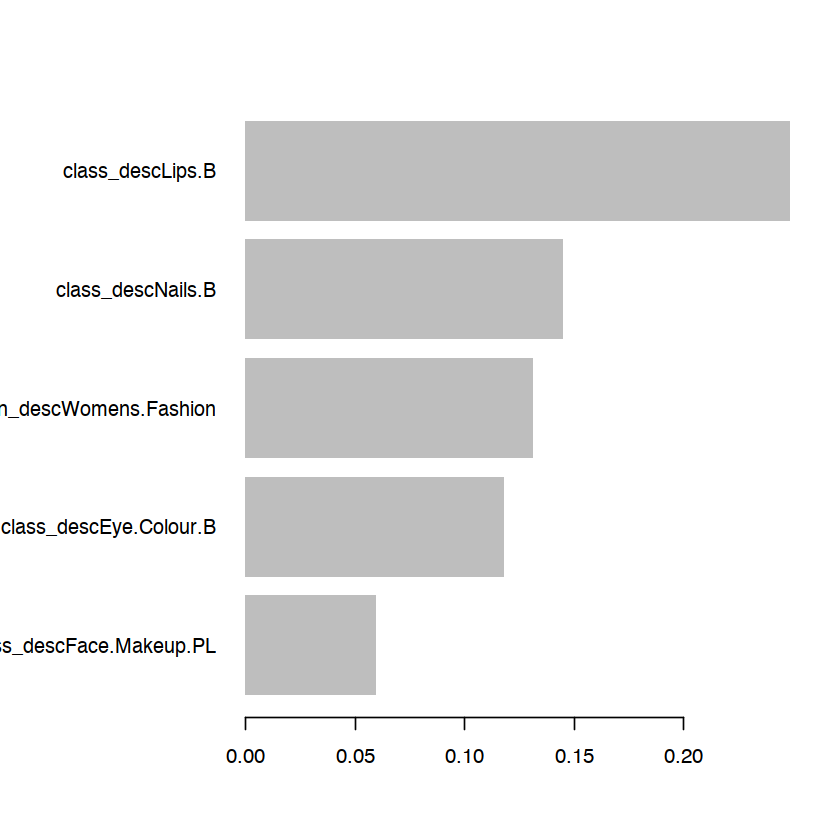

In [5]:
# Nice graph
xgb.plot.importance(importance_matrix[1:5,])

Test accuracy is .87 with some important features shown above.

### Fitting models based on other criteria

Compare some of the models we have trained. The ROC and the 5-fold cross-validation can be comparison metrics. We will evaluate multiple models based on the ROC metric.

In [6]:
control = trainControl(method = "cv", number = 5, 
                       classProbs = T, summaryFunction = twoClassSummary) 
metric = "ROC"

Decision tree, random forest and xgboost is trained.

In [7]:
y = as.factor(ifelse(y>0, "is_returned", "not_returned"))

In [8]:
set.seed(7313)
fit.tree = train(
  x = x[-testid,],
  y = y[-testid],
  method="rpart", 
  metric=metric, 
  trControl=control)
set.seed(7313)
fit.rf = train(
  x = x[-testid,],
  y = y[-testid],
  method="rf", 
  metric=metric, 
  ntree = 30,
  trControl=control)
set.seed(7313)
grid_default = expand.grid(
  nrounds = 10,
  max_depth = 6,
  eta = 0.3,
  gamma = 0,
  colsample_bytree = 1,
  min_child_weight = 1,
  subsample = 1
)
fit.xgb = train(
  x = x[-testid,],
  y = y[-testid],
  trControl = control,
  tuneGrid = grid_default,
  method = "xgbTree",
  metric = metric
)

Now we can compare training accuracy of all models:

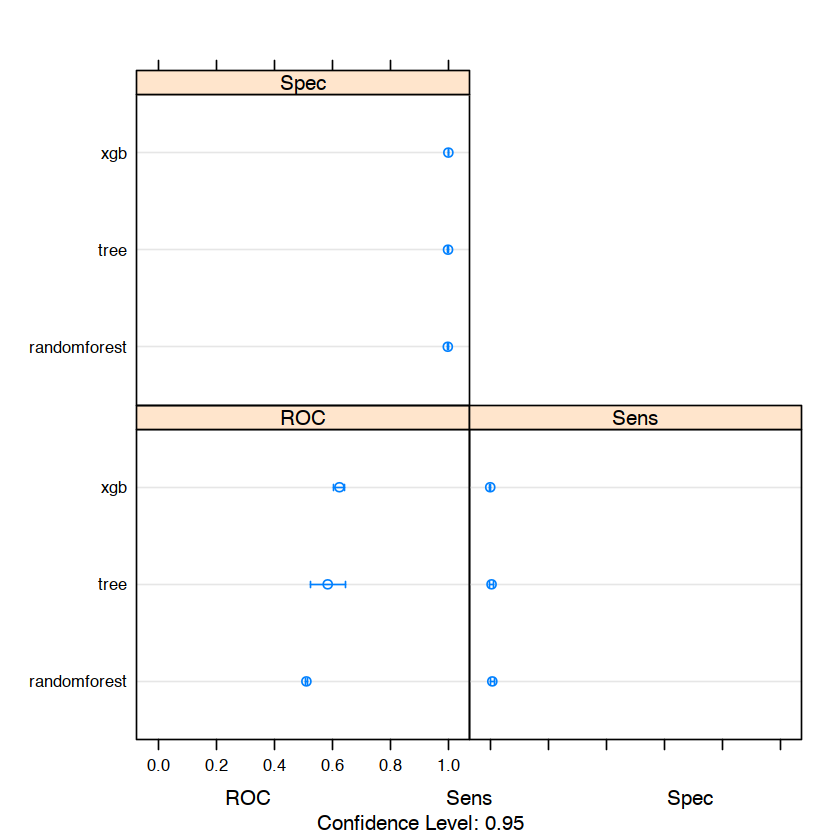

In [9]:
results = resamples(list(
  tree = fit.tree, 
  randomforest = fit.rf, 
  xgb = fit.xgb))
dotplot(results)

We only evaluate training accuracy, but we use cross validation when we train the models. We pick XGBoosting as it has the highest performance level.

Check Deeplearning

Loaded Tensorflow version 2.9.3



[1] 0.87

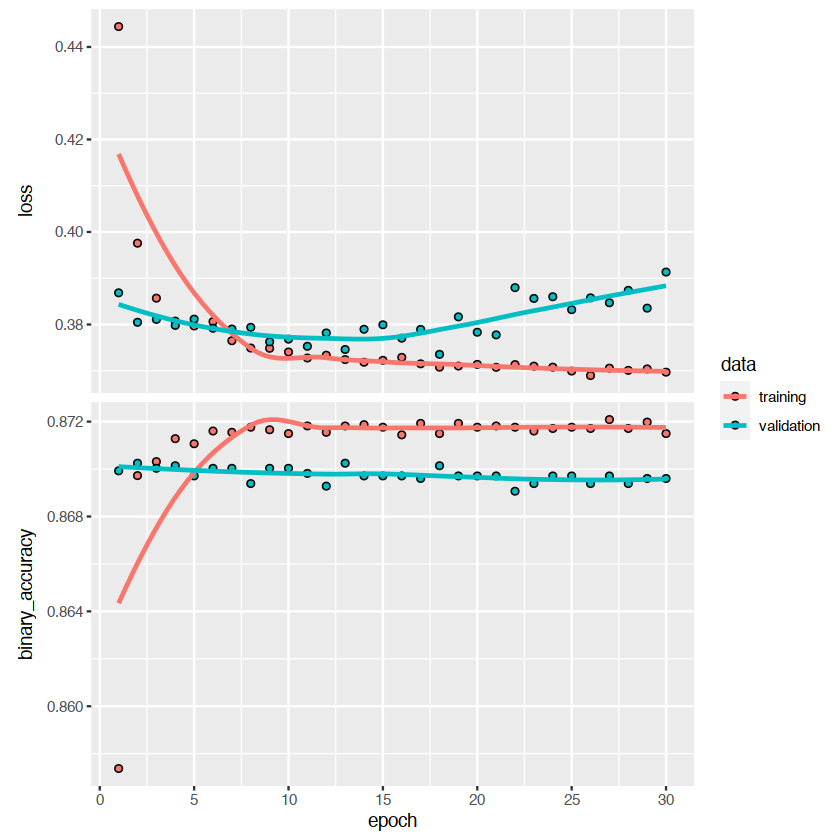

In [10]:
library(keras)
#create a sequential model
modnn = keras_model_sequential()  %>%
  # Input layer
  layer_dense(units = 50, activation = "relu",
              input_shape =  ncol(x)) %>% 
  #layer_dropout(rate = 0.4) %>% 
  # Hidden layer
  #layer_dense(units = 75, activation = "relu") %>%
  # Output layer: final output is one var
  layer_dropout(rate = 0.4) %>%
  layer_dense(units = 1, activation = "sigmoid")

#compile
modnn %>% compile(
  loss = 'binary_crossentropy',
  optimizer = 'adam',
  metrics = 'BinaryAccuracy'
  )

#target as num
y = trsf$is_returned
#fit the neural network
history = modnn %>% 
  fit(x[-testid,], #predictor-matrix
      y[-testid], #target-vector 
      epochs = 30, #1500 in ISLR example  
      batch_size = 32,  
      validation_data = list(x[testid,],y[testid])
      #verbose = 1
      )  
#history of loss and accuracy metrics
plot(history) 

y_pred = modnn %>% 
  predict(x[testid,]) %>% 
  '>'(0.5) %>%
  ifelse(1,0) 
acc = round(mean(y_pred == y[testid]),2)
acc

In [11]:
y_pred = modnn %>% 
  predict(x[testid,]) %>% 
  '>'(0.5) %>%
  ifelse(1,0) 
acc = round(mean(y_pred == y[testid]),2)
acc

[1] 0.87

The difference in model performance is very small compared to xgboost. we should apply *Occam's Razor* principle: when faced with several methods that give roughly equivalent performance, pick the simplest. Thus, our final model is xgboost.